# Resources:
$ \varphi + \Sigma + \sum^{\inf}_{i=\pi}2$
* [extract clean text from html](https://stackoverflow.com/questions/328356/extracting-text-from-html-file-using-python)
* [extract clean text from pdf](https://www.geeksforgeeks.org/extract-text-from-pdf-file-using-python/)
* [word cloud tutorial](https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5)
* [more choropleth stuff](https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e)
* [another source of data, openstates](https://openstates.org/)
* [graphs of bill sponsors](https://blog.jupyter.org/interactive-graph-visualization-in-jupyter-with-ipycytoscape-a8828a54ab63)

In [48]:
from bs4 import BeautifulSoup as Soup
import glob
from itertools import islice
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    
def extract_html_file(file_path: str):
    soup = None
    with open(file_path, 'r') as f:
        soup = Soup(f, 'html.parser')

    for script in soup(["script", "style"]):
        script.extract()    # rip it out

    text = soup.get_text()
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)

    return text

corpus = ''
for file in glob.glob('bills/*.html'):
    try:
        corpus = corpus + extract_html_file(file)
    except Exception as e:
        print(f'Failed to extract text from {file}: {e}')
    
print(len(corpus))

Failed to extract text from bills/VA_HB1387.html: 'utf-8' codec can't decode byte 0x96 in position 95: invalid start byte
Failed to extract text from bills/AZ_SB1700.html: 'utf-8' codec can't decode byte 0xa0 in position 9298: invalid start byte
Failed to extract text from bills/AZ_SB1028.html: 'utf-8' codec can't decode byte 0xa0 in position 3283: invalid start byte
Failed to extract text from bills/AZ_SB1417.html: 'utf-8' codec can't decode byte 0xa0 in position 8123: invalid start byte
Failed to extract text from bills/AZ_SB1030.html: 'utf-8' codec can't decode byte 0xa0 in position 4440: invalid start byte
Failed to extract text from bills/AZ_SB1698.html: 'utf-8' codec can't decode byte 0xa0 in position 19905: invalid start byte
Failed to extract text from bills/AZ_SB1702.html: 'utf-8' codec can't decode byte 0xa0 in position 8910: invalid start byte
Failed to extract text from bills/VA_SB1186.html: 'utf-8' codec can't decode byte 0x96 in position 11660: invalid start byte
Failed t

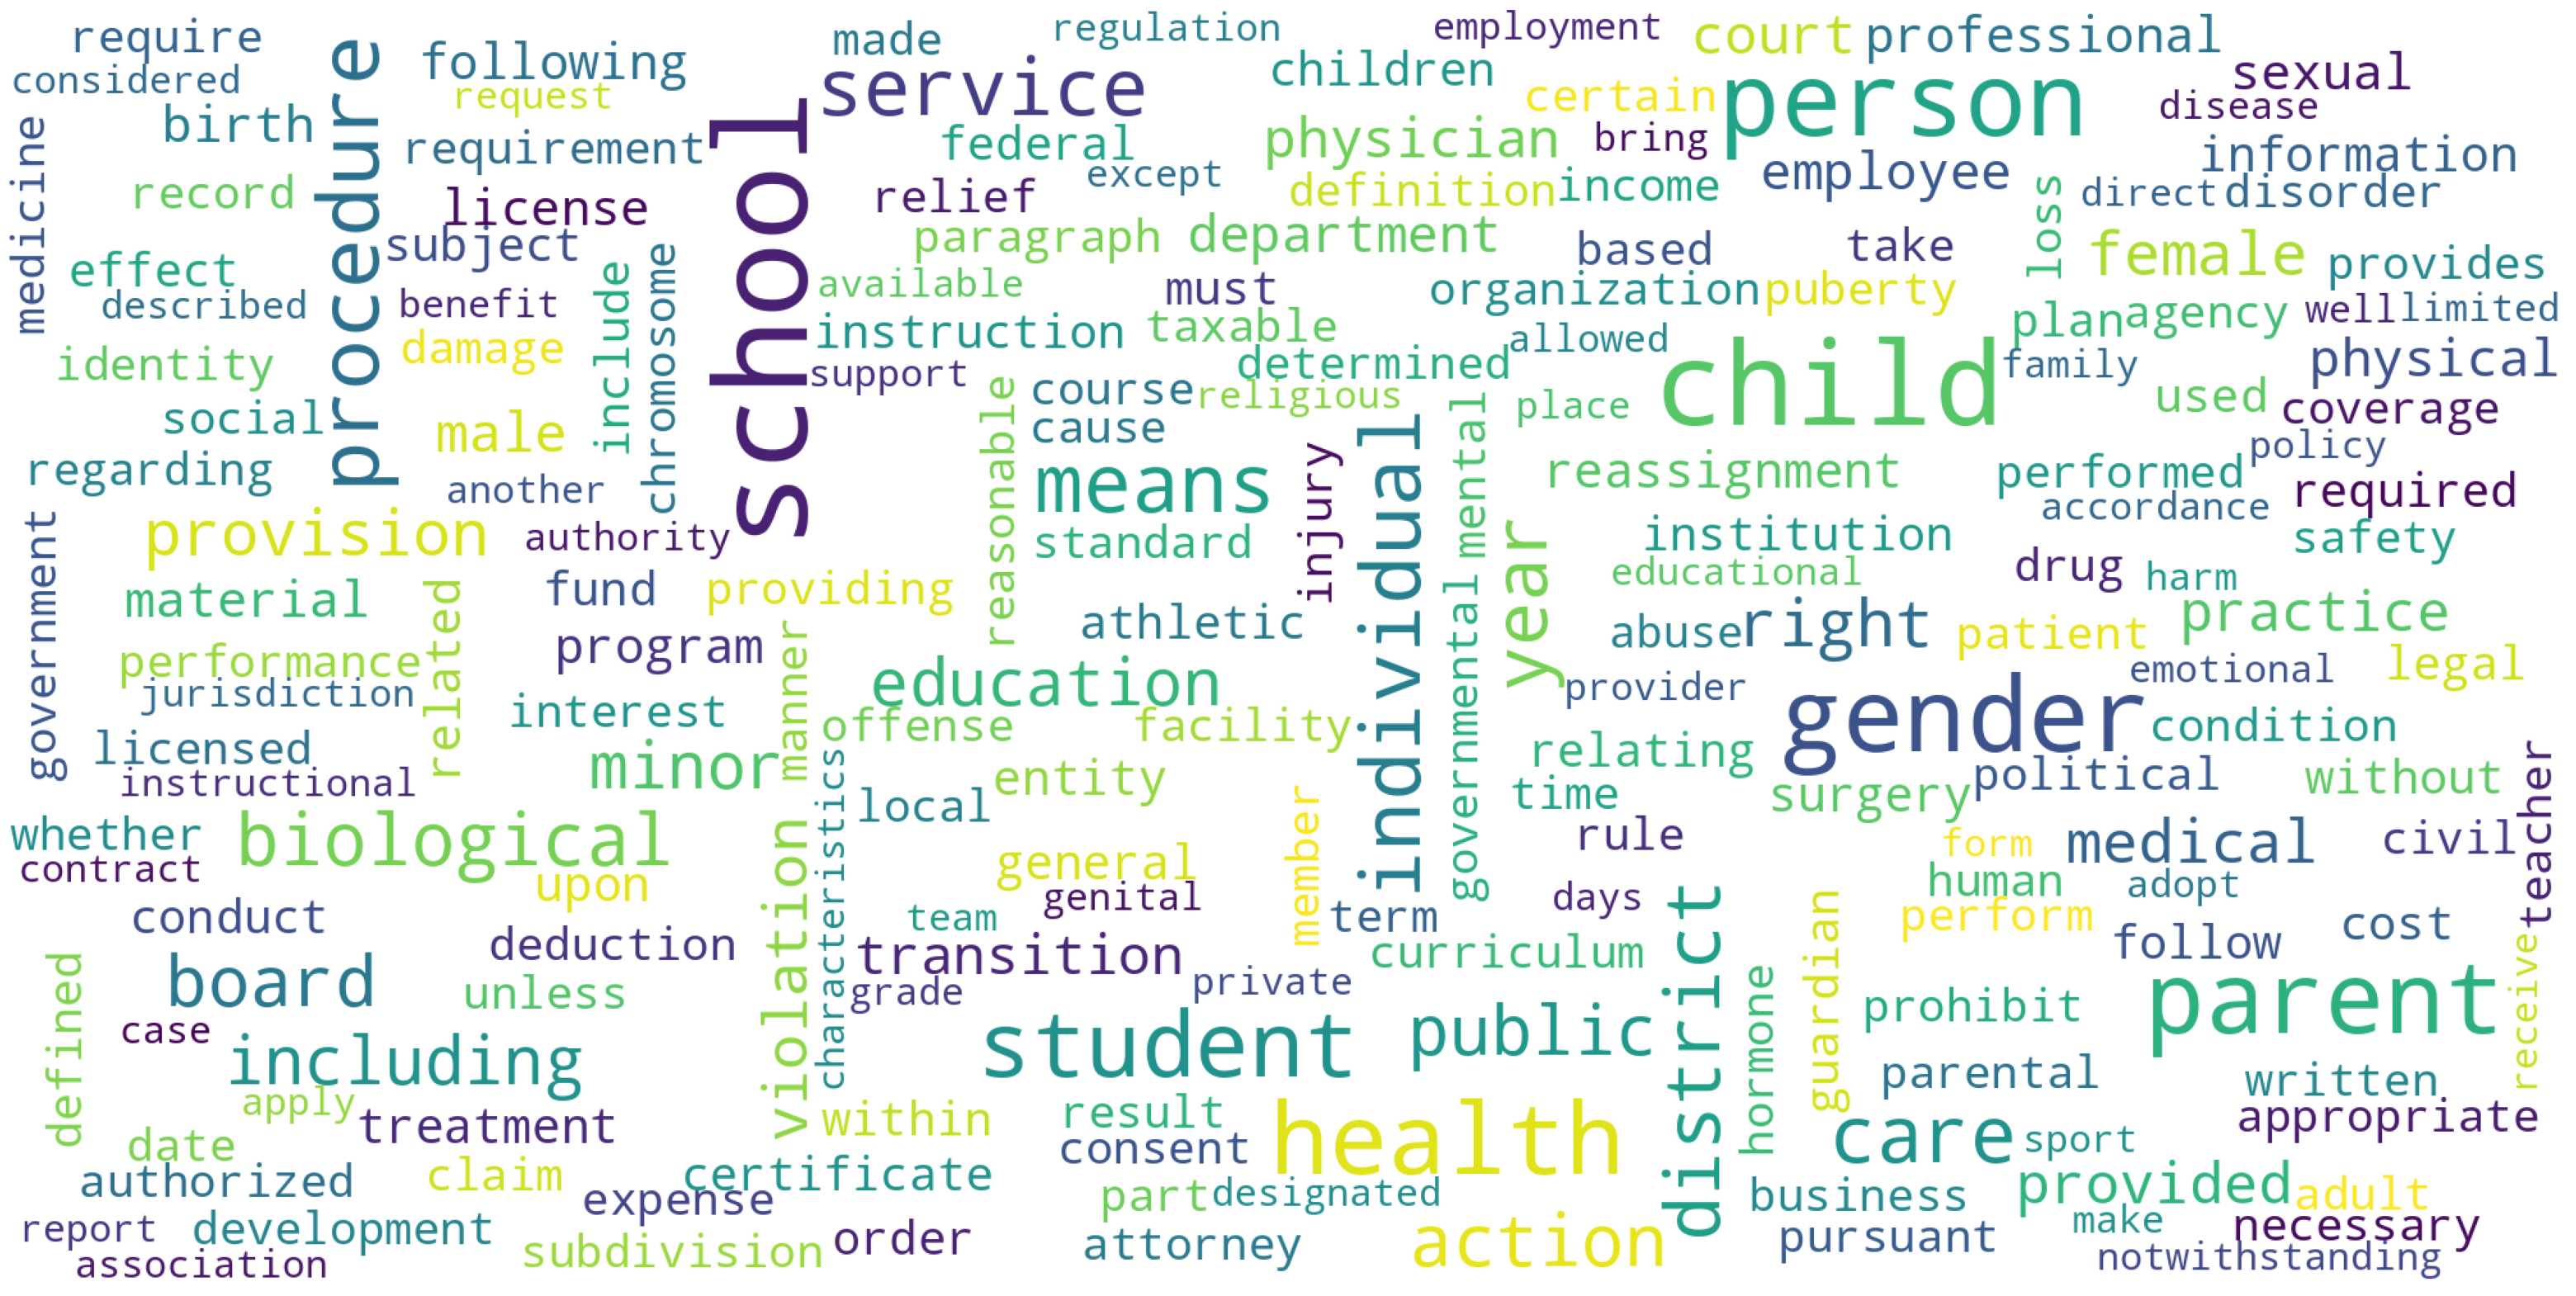

In [58]:
corpus = corpus.lower()

custom_stopwords = []
with open('custom_stopwords.json', 'r') as f:
    custom_stopwords = json.load(f)

STOPWORDS.update(custom_stopwords)

#supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 
# 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 
# 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 
# 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
# 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 
# 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 
# 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 
# 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 
# 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 
# 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 
# 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 
# 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 
# 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

# Generate word cloud
wordcloud = WordCloud(
    width=2000, 
    height=1000,
    random_state=2, 
    background_color='white', 
    colormap='viridis', 
    collocations=False, 
    stopwords=STOPWORDS,
    max_words=200,
    min_word_length=4,
    max_font_size=100,
    min_font_size=10,
    relative_scaling=0.6,
)

wordcloud_plot = wordcloud.generate(corpus)

# Plot
plot_cloud(wordcloud_plot)